### Импортируем данные и создаем их копию, с которой и будем работать.

In [1]:
import pandas as pd

initial=pd.read_csv('dataset_3_part_address.csv', sep=';', parse_dates=['Date'], decimal='.')
data=initial.copy()

### Создаем словарь, в котором ключ - номер USPD, значение - количество записей в датасете для этого USPD.

In [2]:
uspd_list=data.drop_duplicates(subset=['USPD'])['USPD'].to_numpy()
uspd_dict={}
for uspd in uspd_list:
    uspd_dict.update({uspd:len(data.loc[data['USPD']==uspd].index)})

### Посмотрим на функции распределения теплопотребления в зависимости от типа регистрации показаний.

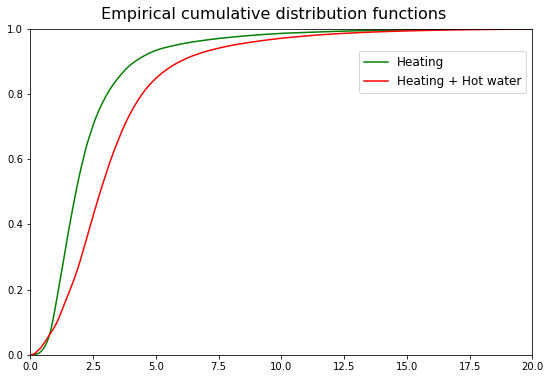

In [3]:
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

data_h = data[data['registrated']=='Heating']['Q'].to_numpy()
data_hh = data[data['registrated']=='Heating + Hot water']['Q'].to_numpy()

ecdf_h = ECDF(data_h)
ecdf_hh = ECDF(data_hh)

fig = plt.figure(figsize=(9, 6))
fig.suptitle('Empirical cumulative distribution functions', fontsize=16, y=0.93)

ax = fig.add_subplot()
ax.plot(ecdf_h.x, ecdf_h.y, label='Heating', color='green')
ax.plot(ecdf_hh.x, ecdf_hh.y, label='Heating + Hot water', color='red')
ax.legend(fontsize=12, bbox_to_anchor=(1, 0.95))
ax.set_xlim(0, 20)
ax.set_ylim(0, 1)

plt.show()

### Строим гистограмму количества этажей в домах.

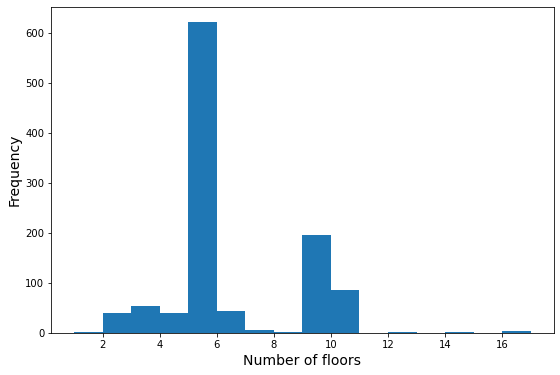

In [4]:
import math

floors=data.drop_duplicates(subset=['Address'])['floors']

n_bins=math.ceil((max(floors) - min(floors)))

fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot()
ax.hist(floors, bins=n_bins)
ax.set_xlabel('Number of floors', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.show()

### Оставляем только стандартные (5, 9 этажей) дома.

In [5]:
data=data.loc[data['floors'].isin([5,9])]

### Строим гистограмму площадей жилых помещений.

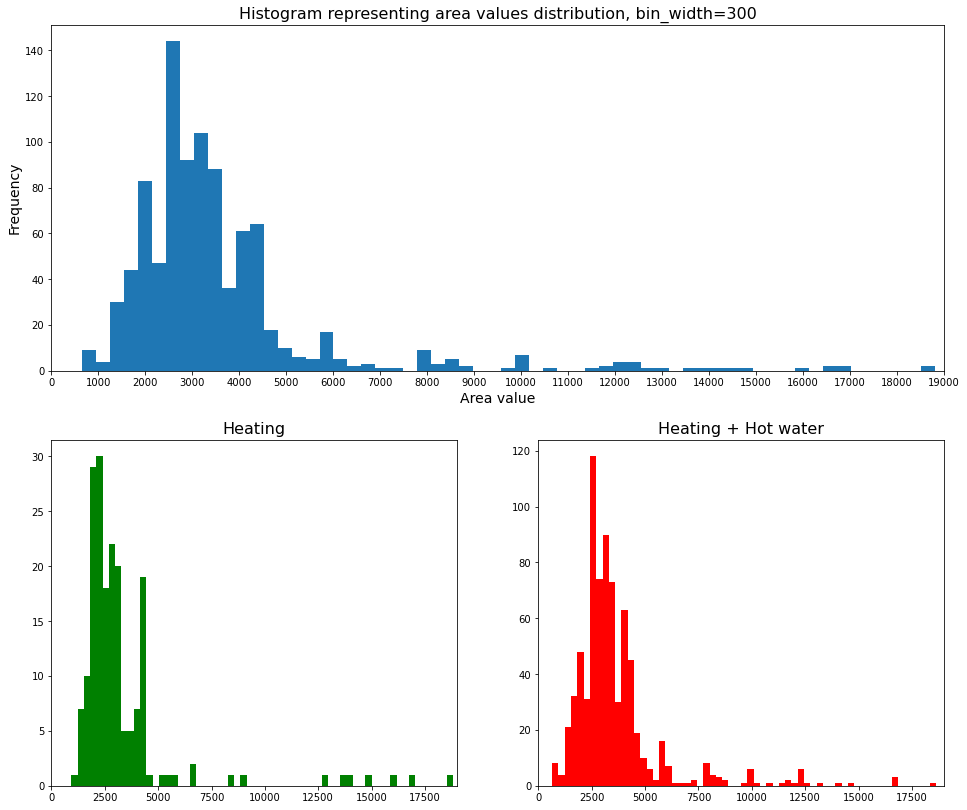

In [6]:
areas=list(set(data['area']))

fig = plt.figure(figsize=(16,14))

bin_width=300
n_bins=math.ceil((max(areas) - min(areas))/bin_width)

ax=plt.subplot2grid((2,2), (0,0), colspan=2)
ax.hist(areas, bins=n_bins)
ax.set_title(f'Histogram representing area values distribution, bin_width={bin_width}', fontsize=16)
ax.set_xlabel('Area value', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlim(0, 19000)
ax.set_xticks([1000*x for x in range(20)])

areas_h=list(set(data[data['registrated']=='Heating']['area']))
areas_hh=list(set(data[data['registrated']=='Heating + Hot water']['area']))

ax_h=plt.subplot2grid((2,2), (1,0))
ax_h.hist(areas_h, bins=n_bins, color='green')
ax_h.set_title('Heating', fontsize=16)
ax_h.set_xlim(0, 19000)

ax_hh=plt.subplot2grid((2,2), (1,1))
ax_hh.hist(areas_hh, bins=n_bins, color='red')
ax_hh.set_title('Heating + Hot water', fontsize=16)
ax_hh.set_xlim(0, 19000)

plt.show()

### Следующая функция разделяет дома в указанном площадном интервале жилых помещений по типу регистрируемых счетчиком показаний, cтроятся гистограммы теплопотребления для обоих типов домов, также указаны:
- Количество показаний в получившейся группе
- Выборочное среднее (mean)
- Среднеквадратичное отклонние (std)
- Коэффициент эксцесса (kurtosis)
- Коэффициент асимметрии (skewness)

In [7]:
from scipy.stats import kurtosis
from scipy.stats import skew 

def split(data: pd.DataFrame, area_left_edge: int, width: int) -> list:
    
    
    uspd_h=list(set(data[(data['registrated']=='Heating') & (data['area']>=area_left_edge)
                    & (data['area']<=area_left_edge+width)]['USPD']))
    
    uspd_hh=list(set(data[(data['registrated']=='Heating + Hot water') & (data['area']>=area_left_edge)
                     & (data['area']<=area_left_edge+width)]['USPD']))
    
    # CUTTING USPD_HH LIST SO THE NUMBER OF READINGS IS COMPARABLE
    
    uspd_hh.sort(key=lambda x: uspd_dict[x], reverse=True)
    readings_count=0
    new_uspd_hh=[]
    
    for uspd in uspd_hh:
        if (readings_count > (stop:=sum([uspd_dict[x] for x in uspd_h]))):
            break
        new_uspd_hh.append(uspd)
        readings_count+=uspd_dict[uspd]
        
    uspd_hh=new_uspd_hh
    
    
    data_h=data[data['USPD'].isin(uspd_h)]['Q'].to_numpy()
    data_hh=data[data['USPD'].isin(uspd_hh)]['Q'].to_numpy()
    
    
    # PLOTTING HISTOGRAMS
    
    bin_width=0.2
    n_bins_h=math.ceil((max(data_h) - min(data_h))/bin_width)
    n_bins_hh=math.ceil((max(data_hh) - min(data_hh))/bin_width)

    fig = plt.figure(figsize=(16, 14))
    fig.suptitle(f'Area in [{area_left_edge}, {area_left_edge+width}], bin_width={bin_width}', y=0.925, fontsize=16)
    
    ax1 = plt.subplot2grid((14,2), (0,0), rowspan=5)
    ax1.hist(data_h, bins=n_bins_h, color='green', label='Heating', density=True)
    ax1.legend(loc=1, fontsize=14)
    ax1.set_xlim(-0.5, 8)
    ax1.set_ylim(0, 0.8)
    ax1.set_xlabel('Q, Gcal', fontsize=14)
    ax1.set_ylabel('Probability density', fontsize=14)
    

    ax2 = plt.subplot2grid((14,2), (0,1), rowspan=5)
    ax2.hist(data_hh, bins=n_bins_hh, color='red', label='Heating + Hot water', density=True)
    ax2.legend(loc=1, fontsize=14)
    ax2.set_xlim(-0.5, 8)
    ax2.set_ylim(0, 0.8)
    ax2.set_xlabel('Q, Gcal', fontsize=14)
    ax2.set_ylabel('Probability density', fontsize=14)
    
    
    # PLOTTING TABLES
    
    columns=('mean', 'std', 'kurtosis', 'skewness')
    info_h=[['%.3f' % data_h.mean(), '%.3f' % data_h.std(), '%.3f' % kurtosis(data_h), '%.3f' % skew(data_h)]]
    info_hh=[['%.3f' % data_hh.mean(), '%.3f' % data_hh.std(), '%.3f' % kurtosis(data_hh), '%.3f' % skew(data_hh)]]

    ax3 = plt.subplot2grid((14,2), (5,0), rowspan=2)
    ax3.set_title(f'number_of_readings = {len(data_h)}', y=0.45, fontsize=14, loc='left')
    
    ax4 = plt.subplot2grid((14,2), (5,1), rowspan=2)
    ax4.set_title(f'number_of_readings = {len(data_hh)}', y=0.45, fontsize=14, loc='left')
    
    ax3.set_axis_off()
    ax4.set_axis_off()

    table1 = ax3.table(cellText=info_h, bbox=[0, -0.2, 1, 0.6], colLabels=columns, cellLoc='center')
    table2 = ax3.table(cellText=info_hh, bbox=[1.2, -0.2, 1, 0.6], colLabels=columns, cellLoc='center')
    table1.set_fontsize(14)
    table2.set_fontsize(14)
    
    
    # HISTOGRAM COMPARISON
    
    ax4 = plt.subplot2grid((14,2), (8,0), rowspan=6, colspan=2)
    ax4.hist(data_h, bins=n_bins_h, label='Heating', density=True, alpha=1, color='green', histtype='step')
    ax4.hist(data_hh, bins=n_bins_hh, label='Heating + Hot water', density=True, alpha=1, color='red', histtype='step')
    ax4.set_xlim(0, min(math.ceil(max(data_hh)),8))
    ax4.set_ylim(0, 0.8)
    ax4.legend(fontsize=14)
    
    plt.show()
    
    print(f'Difference between histograms = {sum(data_hh)-sum(data_h):.2f}',
         f'USPDs for "Heating": {uspd_h}',
         f'USPDs for "Heating + Hot water": {uspd_hh}', sep='\n')

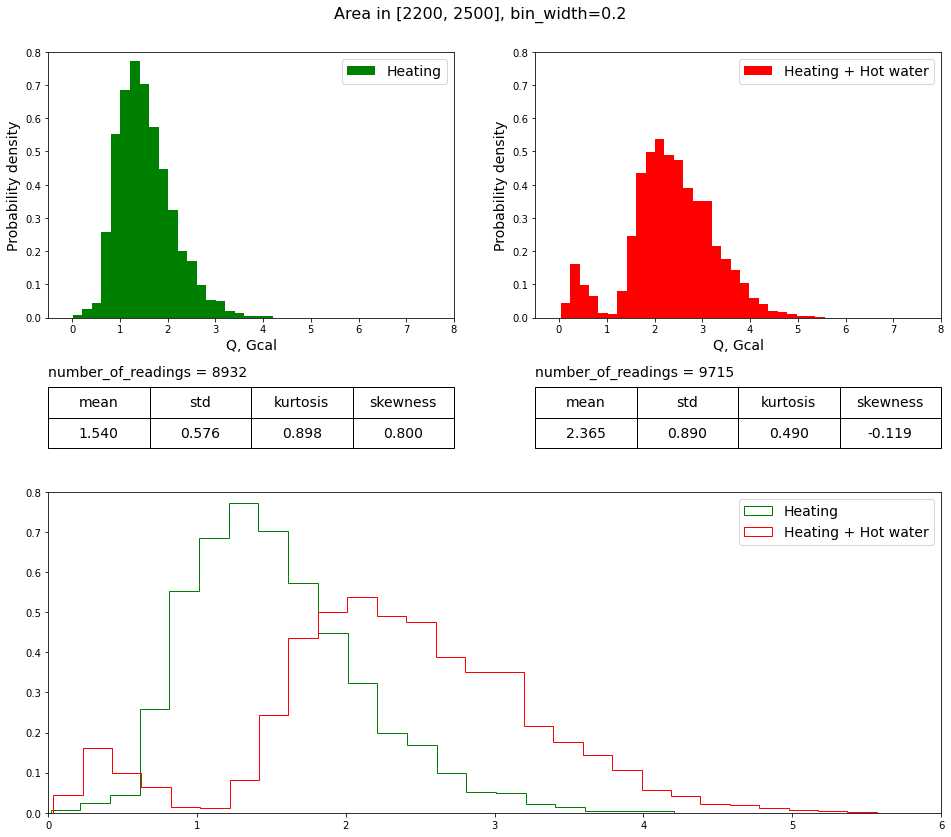

Difference between histograms = 9221.14
USPDs for "Heating": [256, 291, 164, 1607, 72, 1609, 3033, 2205]
USPDs for "Heating + Hot water": [929, 1148, 1986, 1553, 1368, 150]


In [8]:
split(data, 2200, 300)

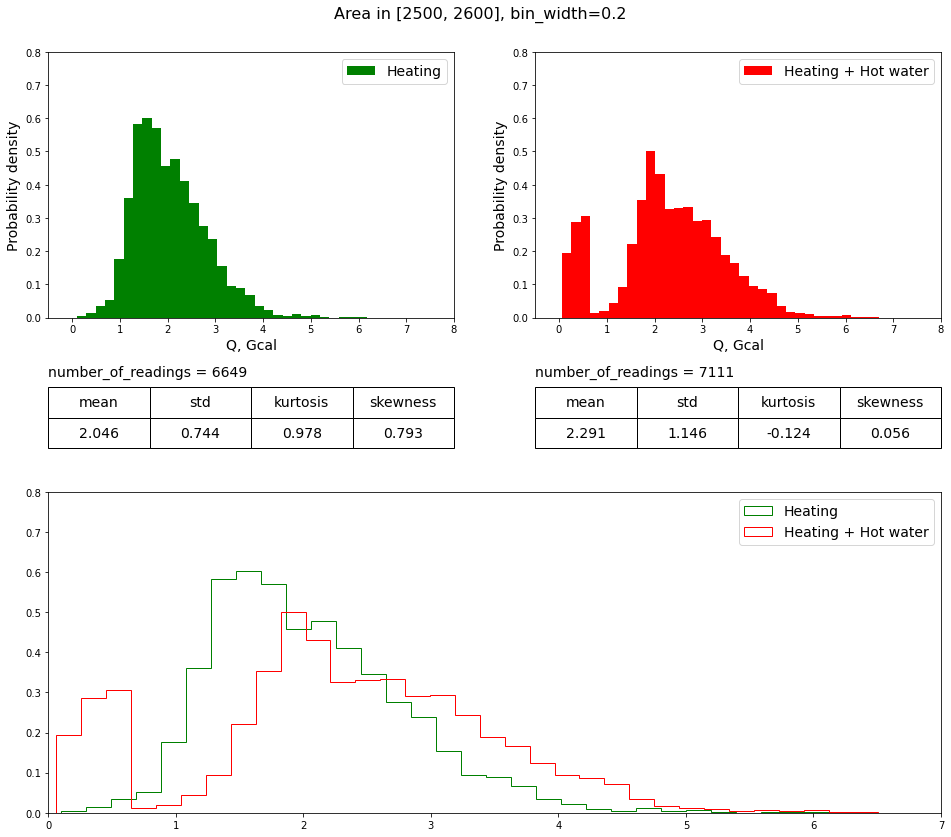

Difference between histograms = 2691.98
USPDs for "Heating": [1537, 104, 105, 1964, 1805, 1749, 351]
USPDs for "Heating + Hot water": [203, 1957, 388, 1740]


In [9]:
split(data, 2500, 100)

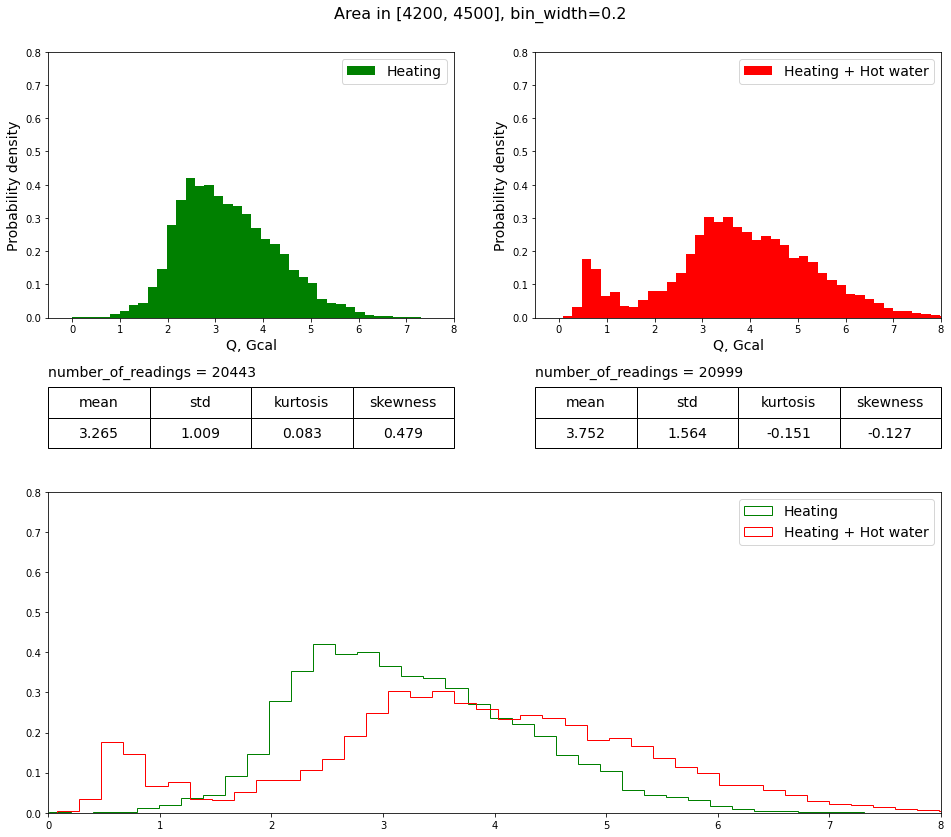

Difference between histograms = 12035.86
USPDs for "Heating": [1952, 354, 356, 357, 359, 360, 1929, 650, 300, 622, 338, 754, 1811, 343, 345, 1468, 349, 311]
USPDs for "Heating + Hot water": [1788, 2045, 322, 870, 2088, 1583, 2025, 1810, 1558, 1806, 380, 1808, 2048]


In [10]:
split(data, 4200, 300)

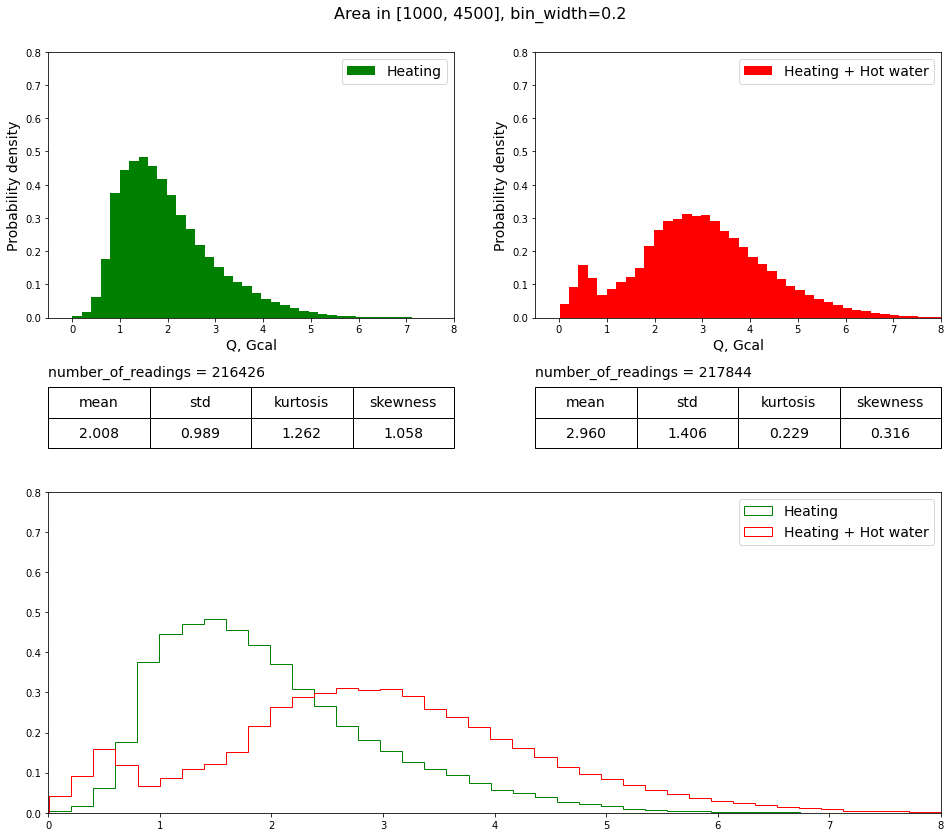

Difference between histograms = 210243.93
USPDs for "Heating": [1536, 1537, 3074, 1539, 3098, 1564, 34, 36, 2091, 2094, 1080, 3129, 1600, 68, 69, 70, 71, 72, 582, 74, 75, 76, 1607, 1609, 79, 80, 81, 1610, 83, 1611, 85, 1615, 87, 2134, 2133, 3162, 613, 102, 1639, 104, 105, 1642, 622, 623, 624, 625, 626, 627, 631, 632, 1143, 124, 126, 127, 130, 643, 644, 648, 1673, 650, 653, 654, 655, 656, 1679, 1680, 1681, 1682, 1683, 1684, 1688, 156, 1692, 1694, 1695, 1696, 2205, 162, 164, 1700, 166, 167, 168, 169, 170, 678, 679, 680, 683, 684, 685, 1704, 1705, 699, 1749, 755, 1249, 232, 233, 240, 241, 242, 243, 244, 245, 752, 754, 248, 249, 250, 251, 1785, 2805, 1790, 246, 256, 257, 1280, 1794, 1795, 1796, 777, 1801, 779, 780, 1803, 1805, 782, 783, 1811, 282, 290, 291, 300, 311, 316, 317, 1862, 332, 334, 337, 338, 343, 345, 349, 351, 352, 353, 354, 355, 356, 357, 359, 360, 366, 371, 1911, 1912, 1703, 1913, 1914, 1929, 1424, 412, 413, 414, 415, 416, 1950, 1952, 1959, 1448, 1960, 1961, 1963, 1964, 1612,

In [11]:
split(data, 1000, 3500)

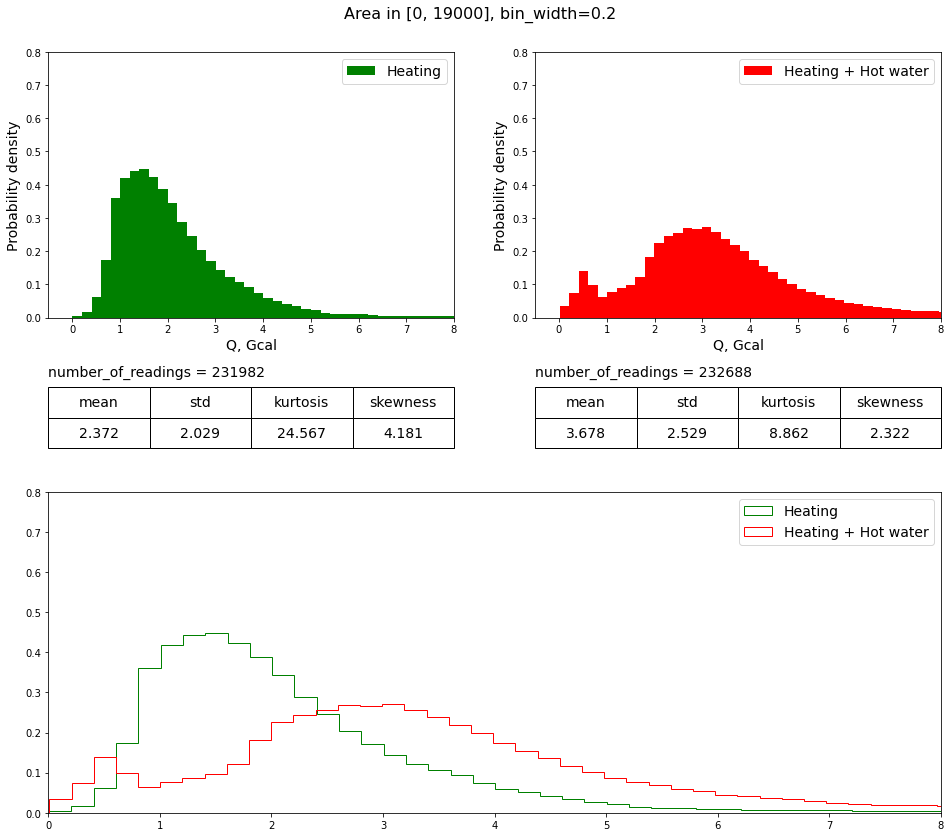

Difference between histograms = 305482.10
USPDs for "Heating": [1536, 1537, 3074, 1539, 13, 3098, 1563, 1564, 34, 36, 2091, 2094, 1080, 3129, 1600, 68, 69, 70, 71, 72, 582, 74, 75, 76, 1604, 1607, 79, 80, 81, 82, 83, 1611, 85, 1613, 87, 1615, 2134, 2133, 3162, 93, 613, 102, 1639, 104, 105, 1642, 622, 623, 624, 625, 626, 627, 631, 632, 1143, 124, 126, 127, 130, 643, 644, 646, 648, 1673, 650, 653, 654, 655, 656, 1679, 1680, 1681, 1682, 1683, 1684, 1688, 156, 1692, 1694, 1695, 1696, 2205, 162, 164, 1700, 166, 167, 168, 169, 170, 678, 679, 680, 683, 684, 685, 1704, 1705, 699, 1723, 1749, 755, 1249, 232, 233, 236, 240, 241, 242, 243, 244, 245, 752, 754, 248, 249, 250, 251, 1785, 2805, 1790, 246, 256, 257, 1280, 1794, 1795, 1796, 777, 1801, 779, 780, 1803, 1805, 782, 783, 1811, 789, 790, 1814, 282, 285, 290, 291, 300, 311, 316, 317, 1862, 332, 334, 337, 338, 343, 344, 345, 349, 351, 352, 353, 354, 355, 356, 357, 359, 360, 366, 371, 1911, 1912, 1703, 1913, 1914, 1929, 1424, 412, 413, 414, 415

In [12]:
split(data, 0, 19000)